In [1]:
# @title Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import hashlib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors


# Set seed for reproducibility
SEED = 47
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# @title Load & Preprocess Data
def load_and_preprocess():
    # Load data
    df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [3]:
# @title Data Engineering
# Load the data again since it was redefined previously
df = pd.read_csv('marketing_campaign.csv', sep='\t')

# Print column names to check if it exists
#print(df.columns)

print("Number of unique values in Z_CostContact column:", df['Z_CostContact'].nunique())
print("Number of unique values in Z_Revenue column:", df["Z_Revenue"].nunique())

# Remove unnecessary columns ('Id' and columns with 1 unique value)
df.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

# Standardize 'Marital_Status' into 2 broader groups
df['Marital_Status'] = df['Marital_Status'].replace(['Married', 'Together'], 'Partner')
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'], 'Single')

# Standardize 'Education' into 3 broader groups
df['Education'] = df['Education'].replace(['PhD', 'Master'], 'Postgraduate')
df['Education'] = df['Education'].replace(['2n Cycle', 'Graduation'], 'Graduate')
df['Education'] = df['Education'].replace(['Basic'], 'Undergraduate')

# Define categorical_columns here
categorical_columns = ['Education', 'Marital_Status']

for column in categorical_columns:
    print(f"Unique values in {column}:")
    print(df[column].unique())
    print("\n")

# Combining columns together to reduce the number of dimensions
df['Kids'] = df['Kidhome'] + df['Teenhome']
df['Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['TotalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
df['TotalNumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

# Converting date to numerical variable by calculating duration
data = df.copy()

# Calculate 'Days_as_client' before selecting columns
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
latest_date = df['Dt_Customer'].max()
df['Days_as_client'] = (latest_date - df['Dt_Customer']).dt.days
df.head()

df = df[['Education', 'Marital_Status', 'Income', 'Kids', 'Days_as_client', 'Recency', 'Expenses',
         'TotalNumPurchases', 'TotalAcceptedCmp', 'Complain', 'Response']]



Number of unique values in Z_CostContact column: 1
Number of unique values in Z_Revenue column: 1
Unique values in Education:
['Graduate' 'Postgraduate' 'Undergraduate']


Unique values in Marital_Status:
['Single' 'Partner']




In [4]:
# @title Clean data
def load_and_preprocess():
    # Load data
    df = pd.read_csv('marketing_campaign.csv', sep='\t')
    df = df.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1)
    df['Income'] = df['Income'].fillna(df['Income'].median())
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
    latest_date = df['Dt_Customer'].max()
    df['Tenure'] = (latest_date - df['Dt_Customer']).dt.days
    df = df.drop('Dt_Customer', axis=1)

    # One-Hot Encoding
    return pd.get_dummies(df, columns=['Education', 'Marital_Status'])

df = load_and_preprocess()

# Categorize columns into three groups based on their data type

binary_columns = [col for col in df.columns if df[col].nunique() == 2]
categorical_columns = [col for col in df.columns if 2 < df[col].nunique() < 10]
numerical_columns = [col for col in df.select_dtypes(include=['number']).columns
                     if col not in binary_columns + categorical_columns]


In [5]:
# @title Remove missing data and outliers

import numpy as np
# Remove missing values
df = df.dropna()

# Remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_cols = df.select_dtypes(include=np.number).columns
df = remove_outliers_iqr(df, numerical_cols)


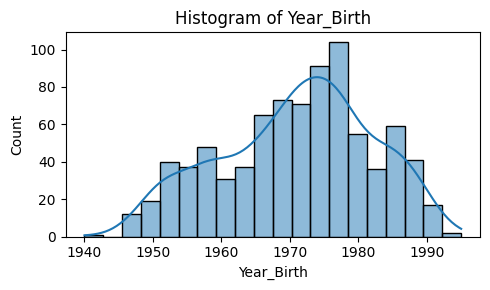

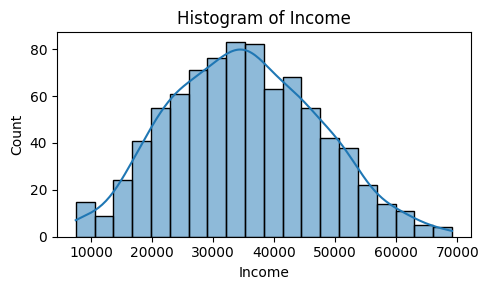

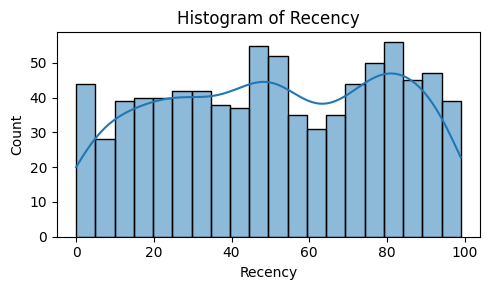

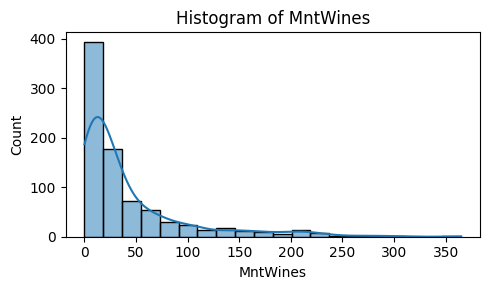

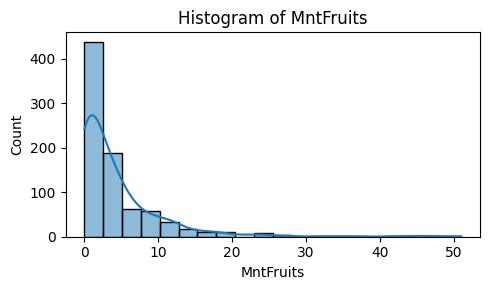

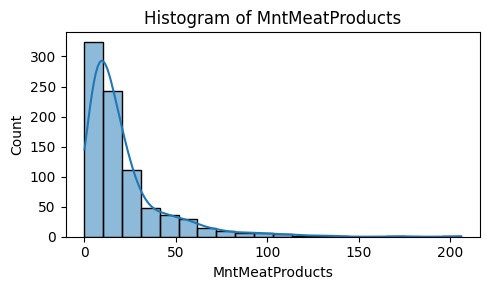

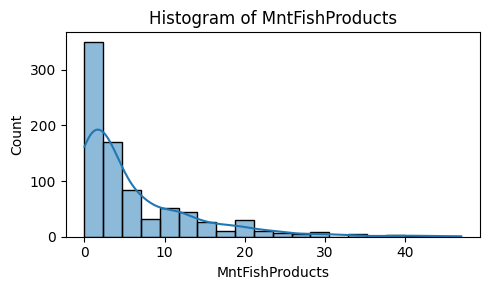

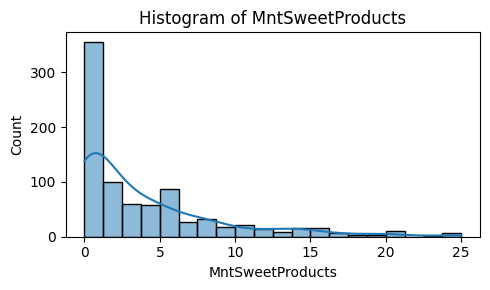

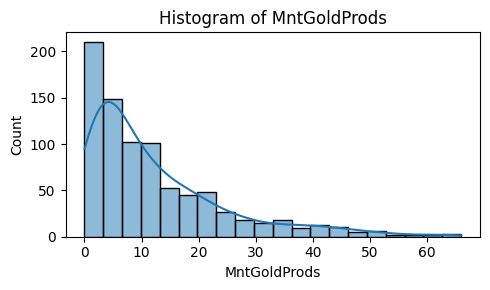

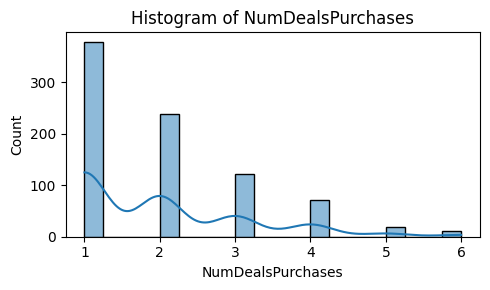

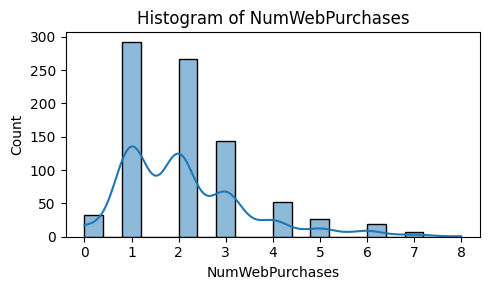

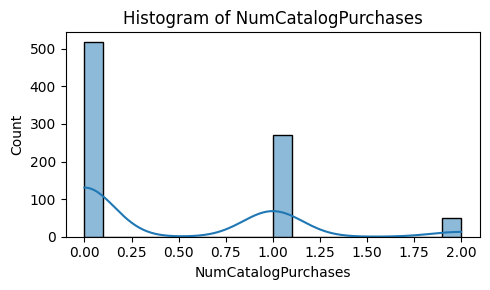

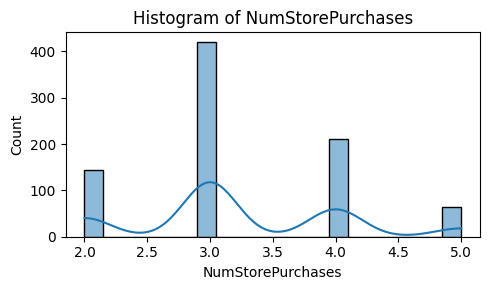

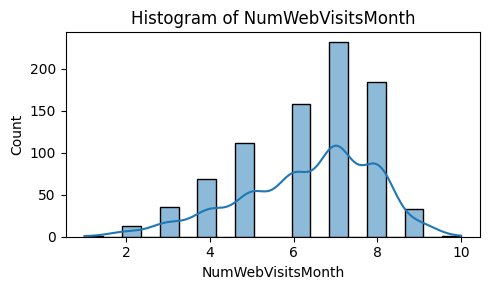

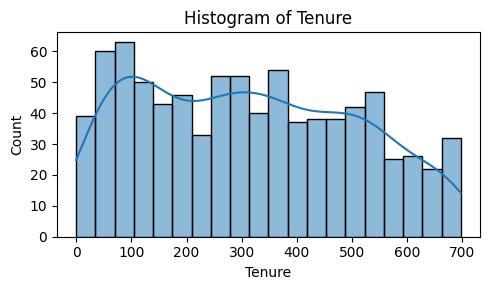

In [6]:
# @title Exploratory Data Analysis

# Plot histograms for each numerical column
for column in numerical_columns:

    plt.figure(figsize=(5, 3))
    sns.histplot(data=df, x=column, kde=True, bins=20)
    plt.title(f'Histogram of {column}')

    plt.tight_layout()
    plt.show()



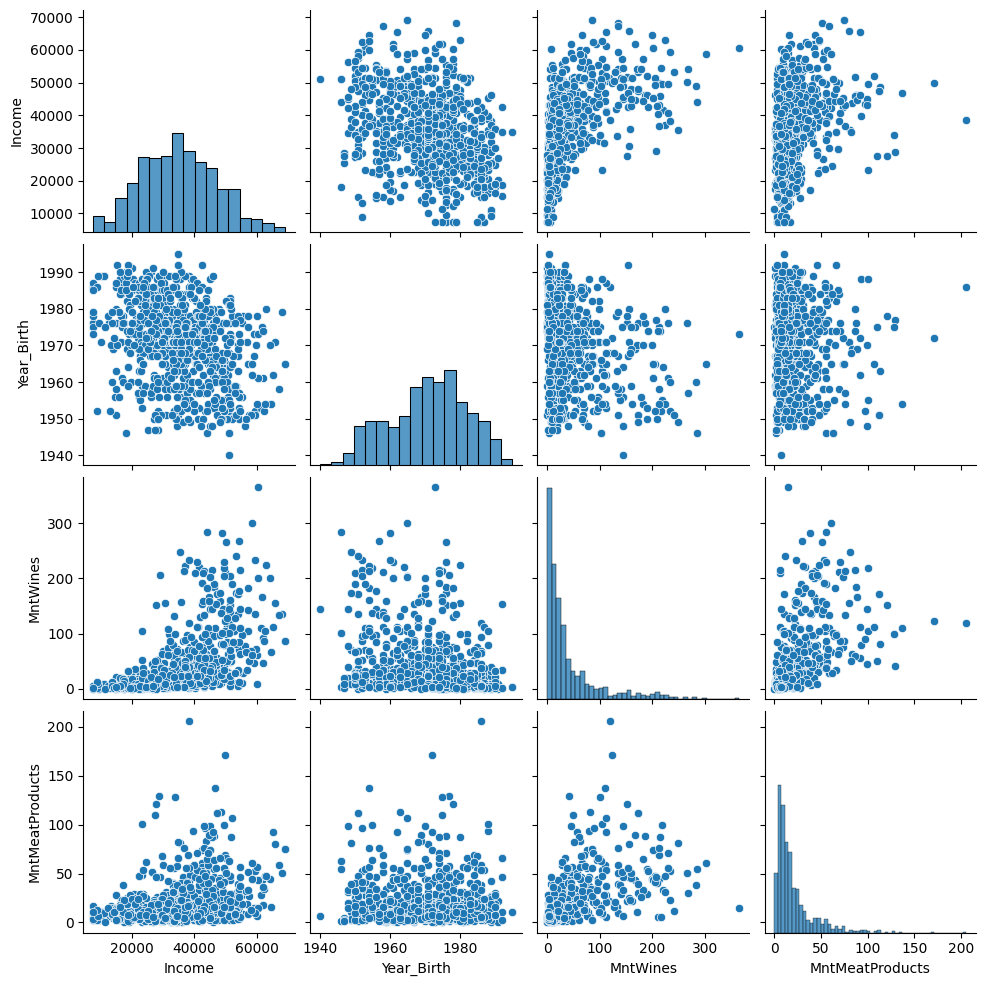

In [7]:

# @title Visualize relationships between multiple variables

sns.pairplot(df[['Income', 'Year_Birth', 'MntWines', 'MntMeatProducts']])
plt.show()


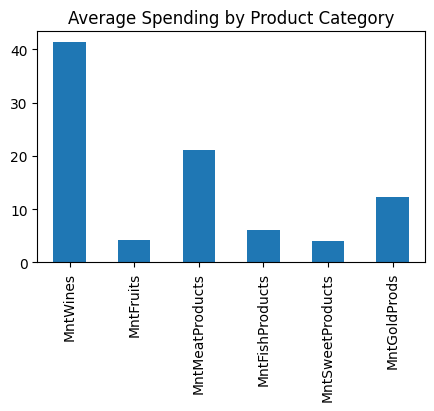

In [8]:

# @title Average Spending by Product Category
# Spending Patterns
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
plt.figure(figsize=(5, 3))
df[spending_cols].mean().plot(kind='bar')
plt.title('Average Spending by Product Category')
plt.show()



In [9]:
# @title Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

In [10]:
# @title Fine tuning

import numpy as np
# @title Fine-tuning Clustering Algorithms
def fine_tune_kmeans(scaled_df):
    """Fine-tunes KMeans clustering."""
    best_score = -1
    best_kmeans = None
    for n_clusters in range(2, 6):  # Try different numbers of clusters
        for init in ['k-means++', 'random']:  # Try different initialization methods
            for max_iter in [300, 500]:  # Try different maximum iterations
                kmeans = KMeans(n_clusters=n_clusters, init=init, max_iter=max_iter, random_state=SEED)
                kmeans_labels = kmeans.fit_predict(scaled_df)
                silhouette_avg = silhouette_score(scaled_df, kmeans_labels)
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_kmeans = kmeans
    return best_kmeans

def fine_tune_dbscan(scaled_df):
    """Fine-tunes DBSCAN clustering."""
    best_score = -1
    best_dbscan = None
    for eps in np.linspace(0.5, 5, 10):  # Try different epsilon values
        for min_samples in range(5, 15):  # Try different minimum samples
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(scaled_df)
            if len(set(dbscan_labels)) > 1:  # Ensure more than one cluster is found
                silhouette_avg = silhouette_score(scaled_df, dbscan_labels)
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_dbscan = dbscan
    return best_dbscan

def fine_tune_hierarchical(scaled_df):
    """Fine-tunes Hierarchical clustering."""
    best_score = -1
    best_agg = None
    for n_clusters in range(2, 6):  # Try different numbers of clusters
        for linkage in ['ward', 'complete', 'average']:  # Try different linkage methods
            agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
            agg_labels = agg.fit_predict(scaled_df)
            silhouette_avg = silhouette_score(scaled_df, agg_labels)
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_agg = agg
    return best_agg


# Fine-tune the clustering algorithms
best_kmeans = fine_tune_kmeans(scaled_df)
best_dbscan = fine_tune_dbscan(scaled_df)
best_agg = fine_tune_hierarchical(scaled_df)

# Use the best models for clustering
kmeans_labels = best_kmeans.fit_predict(scaled_df)
dbscan_labels = best_dbscan.fit_predict(scaled_df)
agg_labels = best_agg.fit_predict(scaled_df)

# Evaluate and analyze the results of the fine-tuned models
print("KMeans Silhouette Score:", silhouette_score(scaled_df, kmeans_labels))
print("DBSCAN Silhouette Score:", silhouette_score(scaled_df, dbscan_labels))
print("Hierarchical Silhouette Score:", silhouette_score(scaled_df, agg_labels))

KMeans Silhouette Score: 0.1856461076075179
DBSCAN Silhouette Score: 0.1783847553161504
Hierarchical Silhouette Score: 0.7599924048868518


In [11]:
# @title Cluster Characterization (Fine-Tuned Models)
def characterize_clusters_tuned(labels, method_name, scaled_df):
    df[f'{method_name}_Cluster'] = labels
    # Select only numeric columns for the mean calculation
    numeric_cols = df.select_dtypes(include=np.number).columns
    cluster_profile = df.groupby(f'{method_name}_Cluster')[numeric_cols].mean()
    print(f"\n{method_name.capitalize()} Cluster Profiles:")
    print(cluster_profile[['Income', 'MntWines', 'MntMeatProducts',
                          'NumDealsPurchases', 'NumWebPurchases']])
    return cluster_profile

# Characterize fine-tuned models
characterize_clusters_tuned(kmeans_labels, 'kmeans_tuned', scaled_df)
characterize_clusters_tuned(dbscan_labels, 'dbscan_tuned', scaled_df)
characterize_clusters_tuned(agg_labels, 'hierarchical_tuned', scaled_df)



Kmeans_tuned Cluster Profiles:
                            Income    MntWines  MntMeatProducts  \
kmeans_tuned_Cluster                                              
0                     32426.322452   20.151274        12.076433   
1                     42824.388626  104.175355        47.767773   

                      NumDealsPurchases  NumWebPurchases  
kmeans_tuned_Cluster                                      
0                              1.689490          1.58121  
1                              2.867299          3.64455  

Dbscan_tuned Cluster Profiles:
                            Income    MntWines  MntMeatProducts  \
dbscan_tuned_Cluster                                              
-1                    43323.416667  104.366667        62.966667   
 0                    35003.044952   38.331950        18.561549   
 1                    20604.300000    2.700000         7.150000   
 2                    41806.125000   34.500000        11.187500   

                      NumDea

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Tenure,kmeans_tuned_Cluster,dbscan_tuned_Cluster,hierarchical_tuned_Cluster
hierarchical_tuned_Cluster,,,,,,,,,,,,,,,,,,,,,
0,1970.934368,35042.363365,0.782816,0.494033,51.201671,41.325776,4.278043,21.048926,6.042959,3.979714,...,0.0,0.0,0.0,0.0,0.0,0.0,312.756563,0.250597,0.015513,0.0
1,1988.000000,34176.000000,1.000000,0.000000,12.000000,5.000000,7.000000,24.000000,19.000000,14.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,48.000000,1.000000,-1.000000,1.0


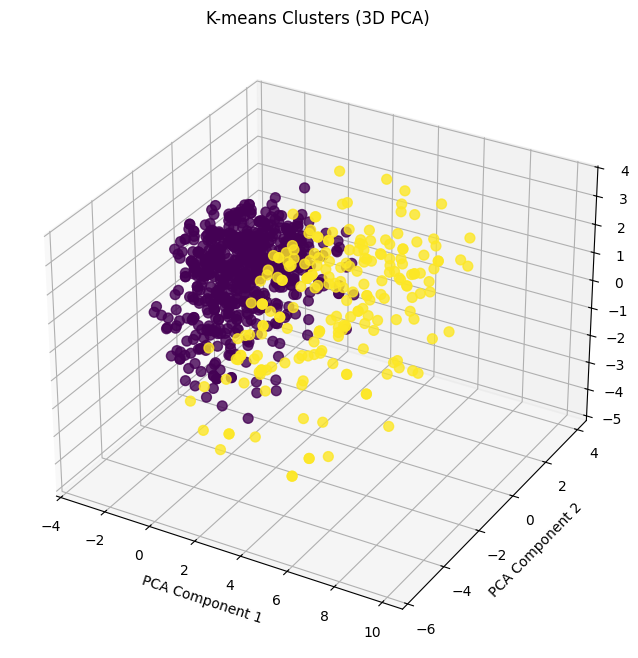

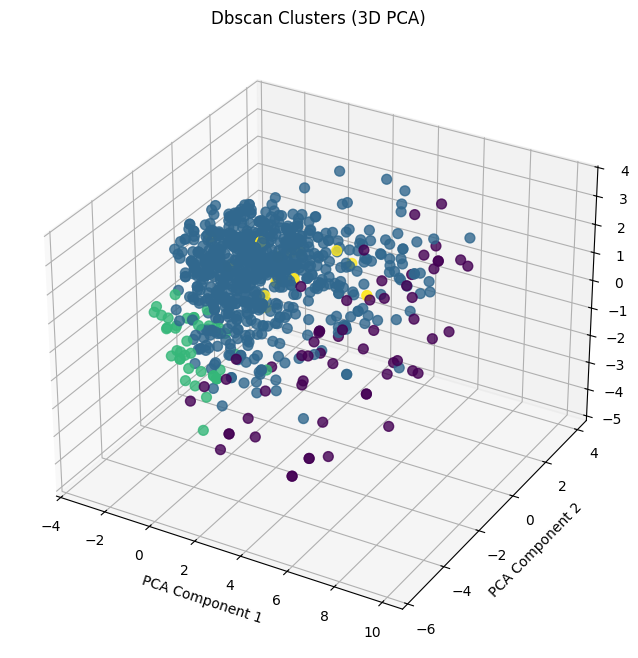

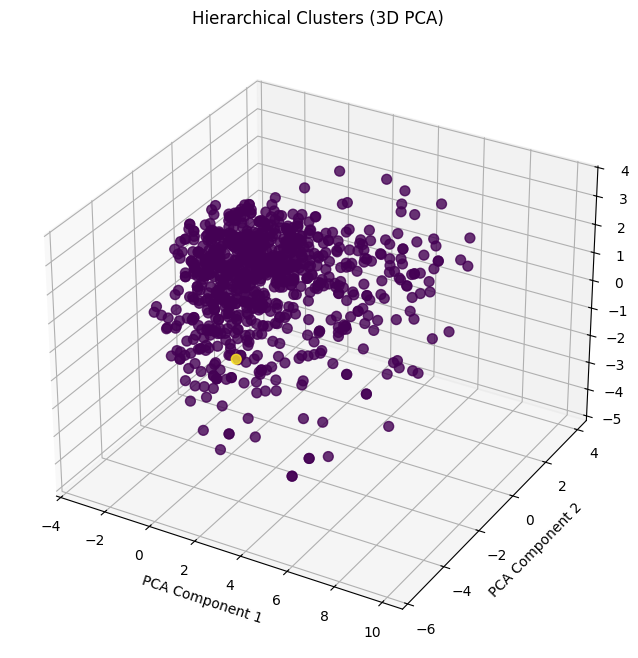

In [12]:
# @title 3D cluster visualization

import matplotlib.pyplot as plt
# Perform PCA with 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_df)

def plot_3d_clusters(labels, method_name):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2],
               c=labels, cmap='viridis', s=50, alpha=0.8)
    ax.set_title(f'{method_name.capitalize()} Clusters (3D PCA)')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    plt.show()


# Plot 3D visualizations for each clustering method
plot_3d_clusters(kmeans_labels, 'K-Means')
plot_3d_clusters(dbscan_labels, 'DBSCAN')
plot_3d_clusters(agg_labels, 'Hierarchical')


In [13]:
# @title Cluster Characterization
def characterize_clusters(labels, method_name):
    df[f'{method_name}_Cluster'] = labels
    # Exclude the cluster label column from the mean calculation
    cluster_profile = df.drop(columns=[col for col in df.columns if '_Label' in col]).groupby(f'{method_name}_Cluster').mean()

    print(f"\n{method_name.capitalize()} Cluster Profiles:")
    print(cluster_profile[['Income', 'MntWines', 'MntMeatProducts',
                          'NumDealsPurchases', 'NumWebPurchases']])

    # Assign labels based on characteristics
    if method_name == 'kmeans':
        labels_map = {
            0: "High-Value Customers", #Big Spenders
            1: "Low-Value Customers", #Budget-Conscious Shoppers (4 cluster)"Premium Customers",
            2: "Deal Seekers",
            3: "Regular Shoppers"
        }
        df[f'{method_name}_Cluster_Label'] = df[f'{method_name}_Cluster'].map(labels_map)

    # Print Cluster Distributions:
    print(f"\n{method_name.capitalize()} Cluster Distributions:")
    print(df[f'{method_name}_Cluster'].value_counts())

    # Print Cluster Distribution Labels (for KMeans):
    if method_name == 'kmeans':
        print(f"\n{method_name.capitalize()} Cluster Distribution Labels:")
        print(df[f'{method_name}_Cluster_Label'].value_counts())

    return cluster_profile

# Define cluster_results before using it
# Assuming you have labels for 'kmeans', 'dbscan', and 'hierarchical' methods
cluster_results = {
    'kmeans': [kmeans_labels],  # Store labels for each method
    'dbscan': [dbscan_labels],
    'hierarchical': [agg_labels]  # Use agg_labels if you have them
}

# Characterize all methods
for method in cluster_results.keys():
    characterize_clusters(cluster_results[method][0], method)

    # Moved the conditional inside the loop and replaced 'method_name' with 'method'
    if method == 'kmeans':
         print(f"\n{method.capitalize()} Cluster Distribution Labels:")
         print(df[f'{method}_Cluster_Label'].value_counts())


Kmeans Cluster Profiles:
                      Income    MntWines  MntMeatProducts  NumDealsPurchases  \
kmeans_Cluster                                                                 
0               32426.322452   20.151274        12.076433           1.689490   
1               42824.388626  104.175355        47.767773           2.867299   

                NumWebPurchases  
kmeans_Cluster                   
0                       1.58121  
1                       3.64455  

Kmeans Cluster Distributions:
kmeans_Cluster
0    628
1    211
Name: count, dtype: int64

Kmeans Cluster Distribution Labels:
kmeans_Cluster_Label
High-Value Customers    628
Low-Value Customers     211
Name: count, dtype: int64

Kmeans Cluster Distribution Labels:
kmeans_Cluster_Label
High-Value Customers    628
Low-Value Customers     211
Name: count, dtype: int64

Dbscan Cluster Profiles:
                      Income    MntWines  MntMeatProducts  NumDealsPurchases  \
dbscan_Cluster                           